In [61]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set the start and end dates
end_date = datetime.now()
start_date = end_date - timedelta(days=3*25)

# Generate a date range for the last 3 years
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Generate synthetic transaction values (representing demand)
np.random.seed(42)  # For reproducibility
transaction_values = np.random.poisson(lam=200, size=len(date_range))

# Generate random vendors
vendors = ['Vendor_A', 'Vendor_B', 'Vendor_C']
vendor_column = np.random.choice(vendors, size=len(date_range))

# Create the DataFrame
df = pd.DataFrame({
    'Date': date_range,
    'Vendor': vendor_column,
    'TransactionValue': transaction_values,
})

# Set the date as the index
df.set_index('Date', inplace=True)

# Display the first few rows of the DataFrame
print(df.head())


                              Vendor  TransactionValue
Date                                                  
2024-06-20 21:00:05.288912  Vendor_C               195
2024-06-21 21:00:05.288912  Vendor_C               210
2024-06-22 21:00:05.288912  Vendor_B               184
2024-06-23 21:00:05.288912  Vendor_B               204
2024-06-24 21:00:05.288912  Vendor_C               216



Processing Vendor: Vendor_C

Processing Vendor: Vendor_B

Processing Vendor: Vendor_A


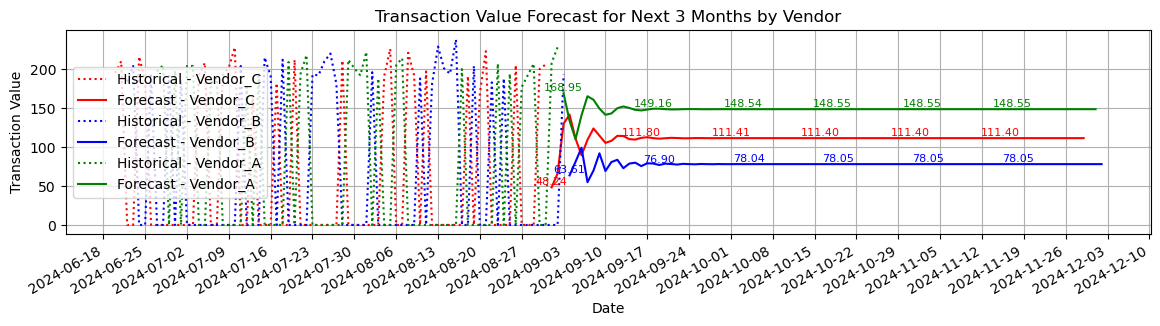

In [71]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA

# Get the list of unique vendors
unique_vendors = df['Vendor'].unique()

# Dictionary to store results
forecast_results = {}

# Colors for the plots
colors = ['red', 'blue', 'green']

plt.figure(figsize=(14, 3))

# Loop over each vendor and fit an ARIMA model
for i, vendor in enumerate(unique_vendors):
    print(f"\nProcessing Vendor: {vendor}")
    
    # Filter the data for the current vendor
    df_vendor = df[df['Vendor'] == vendor].resample('D').sum()  # Aggregate daily
    
    # Fit an ARIMA model
    model = ARIMA(df_vendor['TransactionValue'], order=(5, 1, 0))
    model_fit = model.fit()
    
    # Forecast for the next 90 days
    forecast_steps = 90
    forecast = model_fit.forecast(steps=forecast_steps)
    
    # Create a DataFrame for the forecast
    forecast_dates = pd.date_range(start=df_vendor.index[-1] + timedelta(days=1), periods=forecast_steps, freq='D')
    forecast_df = pd.DataFrame({'Date': forecast_dates, 'ForecastedTransactionValue': forecast})
    forecast_df.set_index('Date', inplace=True)
    
    # Store the forecast results
    forecast_results[vendor] = forecast_df
    
    # Plot historical data
    plt.plot(df_vendor.index, df_vendor['TransactionValue'], label=f'Historical - {vendor}', color=colors[i], linestyle=':')
    
    # Plot forecasted data
    plt.plot(forecast_df.index, forecast_df['ForecastedTransactionValue'], label=f'Forecast - {vendor}', color=colors[i])

    # Annotate forecasted values
    for j in range(0, len(forecast_df), 15):  # Annotate every 15th point to avoid clutter
        plt.text(forecast_df.index[j], forecast_df['ForecastedTransactionValue'].iloc[j],
                 f"{forecast_df['ForecastedTransactionValue'].iloc[j]:.2f}",
                 color=colors[i], fontsize=8, ha='center', va='bottom')

# Customize the X-axis to show week-wise
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Set major ticks to every week
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format ticks as 'Year-Month-Day'
plt.gcf().autofmt_xdate()  # Auto format date labels to prevent overlap

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Transaction Value')
plt.title('Transaction Value Forecast for Next 3 Months by Vendor')
plt.legend()
plt.grid(True)
plt.show()
